# TP3 : Équations différentielles
## PHY-3500: Physique numérique (H2021) - 19 mars 2021


Mélissa Cinq-Mars (111 179 946)

Pierre-Olivier Janvier (111 187 987)

Maxence Larose (111 188 447)

In [1]:
#import packages
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt

### Mécaniques céleste - comètes

#### Question a)

L'équation différentielle qui régit le mouvement du système comète-soleil est donné par:
$$ m \dfrac{d^2\textbf{r}}{dt^2} = - \left (\dfrac{GMm}{r^2} \right ) \dfrac{\textbf{r}}{r} $$

Puisqu'on considère que le mouvement est confiné dans un plan, les deux dimensions nécessaires pour décrire le mouvement sont données par les équations suivantes:
$$ \dfrac{d^2x}{dt^2} = -GM \dfrac{x}{r^3} $$


$$ \dfrac{d^2 y}{dt^2} = -GM \dfrac{y}{r^3} $$

Pour simplifier la démarche analytique, il est préférable de réécrire ces deux équations différentielles du deuxième ordre en quatre équations différentielles du premier ordre en utilisant un changement de variable suivant:

$$ \dfrac{dx}{dt} = v_x   \hspace{2cm}  \dfrac{dv_x}{dt} = -GM \dfrac{x}{r^3} $$

$$ \dfrac{dy}{dt} = v_y   \hspace{2cm}   \dfrac{dv_y}{dt} = -GM \dfrac{y}{r^3} $$

#### Question b)

In [2]:
class RK4_solver:
    """
    Cette classe définit la méthode Runge-Kutta d'ordre 4 qui 
    peut être utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """

    
    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe RK4_solver.
        
        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()
        
        self.func = func
        self.initial_conditions = initial_conditions

        
    def solve(self, initial_value: float, final_value: float, N: int) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches utilisées. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        h = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, h)
        xpoints = []
        ypoints = []

        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            xpoints.append(r[0])
            ypoints.append(r[1])
            
            r += self.get_delta(r, h)
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints
    
    
    def get_delta(self, r: np.ndarray, h: float) -> float:
        """
        Getter de la valeur de la mise à jour à effectuer sur les variables du système d'équation.
        
        Parameters
        ----------
        r: Les valeurs des différentes variables du système. (np.ndarray)
        h: La grandeur du pas à effectuer. (float) 

        Returns
        -------
        delta: La mise à jour à effectuer sur les différentes variables du système. (float)
        """
        k1 = h*self.func(r)
        k2 = h*self.func(r+0.5*k1)
        k3 = h*self.func(r+0.5*k2)
        k4 = h*self.func(r+k3)
        delta = (k1 + 2*k2 + 2*k3 + k4)/6 
        
        return delta
        

In [3]:
def gravitational_differential_equations(r):
    """
    Système de 4 équations différentielles du premier ordre régissant le mouvement d'un corps autour du Soleil.

    Parameters
    ----------
    r: Les valeurs des différentes variables du système. (np.ndarray)

    Returns
    -------
    Les valeurs des 4 dérivées utilisées dans le système d'équation. (np.ndarray) 
    """
    G = const.G
    M = const.M_sun
    
    x, y, vx, vy = r
    R = np.sqrt(x**2 + y**2)

    f_x = vx
    f_y = vy
    f_vx = -G.value*M.value*x*R**-3
    f_vy = -G.value*M.value*y*R**-3
    
    return np.array([f_x, f_y, f_vx, f_vy], float)


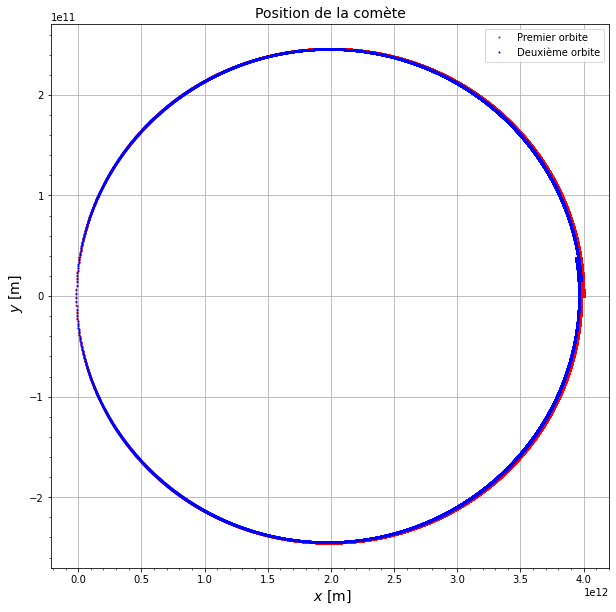

In [4]:
x0 = 4*10**12
y0 = 0
vx0 = 0
vy0 = 500 
initial_conditions = [x0, y0, vx0, vy0]
orbit_comet = RK4_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

initial_time = 0
final_time = 3.156e7*100
N = 100_000

xpoints, ypoints = orbit_comet.solve(initial_value=initial_time, final_value=final_time, N=N)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(np.split(xpoints, 2)[0], np.split(ypoints, 2)[0], marker='o', ls='None', color='r', markersize=1, 
                label="Premier orbite")
line2, = ax.plot(np.split(xpoints, 2)[1], np.split(ypoints, 2)[1], marker='o', ls='None', color='b', markersize=1,
                label="Deuxième orbite")

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()
ax.legend()

plt.grid()
plt.show()
plt.close(fig)


#### Question c)

In [5]:
class RK4_adaptative_solver(RK4_solver):
    """
    Cette classe définit la méthode Runge-Kutta d'ordre 4 
    à pas adaptatif qui peut être utilisée pour résoudre les 
    équations différentielles décrivant le mouvement d'un 
    corps en orbite autour d'un autre, soit le Soleil dans 
    le cas présent.
    """
    
    
    def solve(self, initial_value: float, final_value: float, delta: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        delta: Précision souhaitée par unité de la variable indépendante (le temps habituellement). (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        h = (final_value-initial_value)/10_000

        r = np.array(self.initial_conditions, float)
        
        tpoints = [initial_value, ]
        xpoints = [r[0], ]
        ypoints = [r[1], ]
        
        t = initial_value
        rho = 1
        while t < final_value:
            if rho < 2:
                h = h*(rho**(1/4))
            else:
                h = 2*h
            
            r1 = r + self.get_delta(r=r, h=h)
            r1 = r1 + self.get_delta(r=r1, h=h)
            
            r2 = r + self.get_delta(r=r, h=2*h)
            
            diff = r1 - r2
            rho = 30*h*delta/(np.sqrt(diff[0]**2 + diff[1]**2))
            
            if rho > 1:
                t = t + 2*h
                r = r1
                tpoints.append(t)
                xpoints.append(r[0])
                ypoints.append(r[1])
        
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints


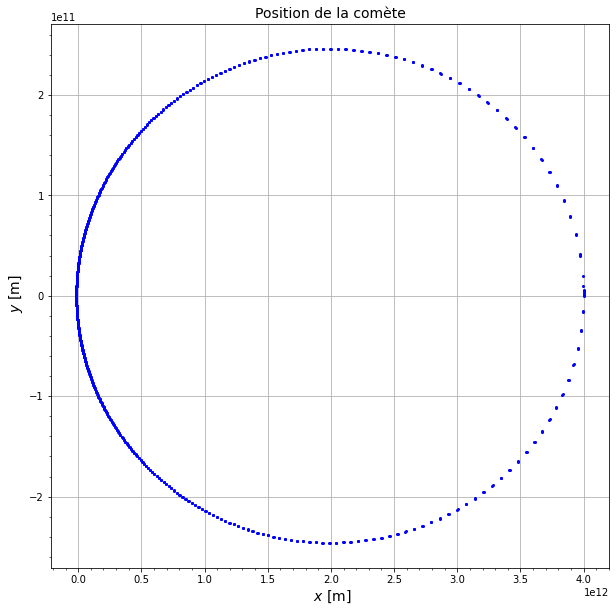

In [6]:
x0 = 4*10**12
y0 = 0
vx0 = 0
vy0 = 500 
initial_conditions = [x0, y0, vx0, vy0]
    
orbit_comet = RK4_adaptative_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

initial_time = 0
final_time = 3.156e7*100
delta = 1e3/(365*24*3600)

xpoints, ypoints = orbit_comet.solve(initial_value=initial_time, final_value=final_time, delta=delta)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

line1, = ax.plot(xpoints, ypoints, marker='o', ls='None', color='b', markersize=2)
# line1, = ax.plot(np.split(xpoints, 2)[0], np.split(ypoints, 2)[0], marker='o', ls='None', color='r', markersize=2)
# line2, = ax.plot(np.split(xpoints, 2)[1], np.split(ypoints, 2)[1], marker='o', ls='None', color='b', markersize=2)

ax.set_title("Position de la comète", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)

### Mécanique céleste - la Terre

#### Question d)

In [7]:
class Verlet_solver:
    """
    Cette classe définit la méthode de Verlet qui peut être 
    utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """
    
    
    def __init__(self, func, initial_conditions: list):
        """
        Constructeur de la classe Verlet_Solver.

        Parameters
        ----------
        func: Fonction qui décrit le système d'équations différentielles étudiés. (Function)
        initial_conditions: Liste des valeurs initiales des différentes dérivées du système d'équation. (list)

        Returns
        -------
        None
        """
        super().__init__()

        self.func = func
        self.initial_conditions = initial_conditions
    
    
    def solve(self, initial_value: float, final_value: float, h: float) -> tuple:
        """
        Méthode de résolution du système d'équation. 
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        h: Pas utilisé. (float)

        Returns
        -------
        xpoints, ypoints: Les valeurs des points x et y évaluées à chaque pas. (float, float)
        """
        tpoints = np.arange(initial_value, final_value, h)
        xpoints = []
        ypoints = []

        r = np.array(self.initial_conditions, float)
        f_mid = 0.5*h*self.func(r)

        vx_mid = r[2] + f_mid[2]
        vy_mid = r[3] + f_mid[3]

        for t in tpoints:
            xpoints.append(r[0])
            ypoints.append(r[1])
            r[0] += h*vx_mid
            r[1] += h*vy_mid

            k = h*self.func(r)
            r[2] += vx_mid + 0.5*k[2]
            r[3] += vy_mid + 0.5*k[3]
            f_mid = 0.5*h*self.func(r)
            vx_mid += k[2]
            vy_mid += k[3]
            
        xpoints, ypoints = np.asarray(xpoints), np.asarray(ypoints)
        
        return xpoints, ypoints
        

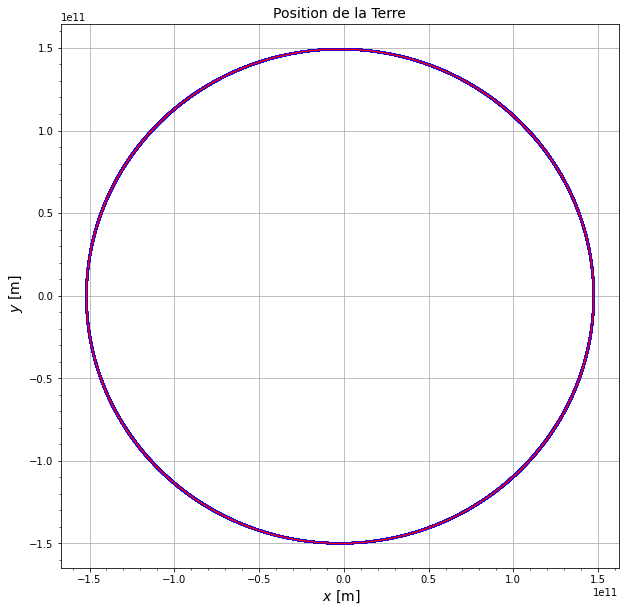

In [8]:
x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  #Vitesse en m/s

initial_conditions = [x0, y0, vx0, vy0]

orbit_earth = Verlet_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

h = 3600   # Une heure


""" Premier orbitre de la comète """
initial_time = 0
final_time = 3.156e7 # 1 an
tpoints1 = np.arange(initial_time, final_time, h)

xpoints1, ypoints1 = orbit_earth.solve(initial_value=initial_time, final_value=final_time, h=h)


""" Deuxième orbitre de la comète """
initial_time = 3.156e7 # 1 an
final_time = 3.156e7*2 # 2 ans
tpoints2 = np.arange(initial_time, final_time, h)

xpoints2, ypoints2 = orbit_earth.solve(initial_value=initial_time, final_value=final_time, h=h)


""" Figure de l'orbite"""
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(xpoints1, ypoints1, marker='o', ls='None', color='b', markersize=2)
orbit2, = ax.plot(xpoints2, ypoints2, marker='o', ls='None', color='r', markersize=0.2)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


#### Question e)

In [9]:
def get_energies(self, initial_value: float, final_value: float, h: float) -> tuple:
    """
    Getter des énergies cinétique, potentielle et totale.

    Parameters
    ----------
    initial_value: Valeur initiale de la variable indépendante. (float)
    final_value: Valeur finale de la variable indépendante. (float)
    h: Pas utilisé. (float)

    Returns
    -------
    tpoints, P, K, total_energy: Le temps, l'énergie potentielle, l'énergie cinétique et l'énergie totale. (tuple)
    """
    G = const.G
    M = const.M_sun
    m = const.M_earth

    tpoints = np.arange(initial_value, final_value, h)
    xpoints = []
    ypoints = []
    P = [] #Énergie potentielle 
    K = [] #Énergie cinétique

    r = np.array(self.initial_conditions, float)
    f_mid = 0.5*h*self.func(r)

    vx_mid = r[2] + f_mid[2]
    vy_mid = r[3] + f_mid[3]
    
    
    for t in tpoints:
        R = np.sqrt(r[0]**2 + r[1]**2)
        P.append(-G.value * M.value * m.value / R)
        K.append(0.5 * m.value * (r[2]**2 + r[3]**2))
        r[0] += h * vx_mid
        r[1] += h * vy_mid
        k = h * self.func(r)
        r[2] = vx_mid + 0.5 * k[2]
        r[3] = vy_mid + 0.5 * k[3]
        f_mid = 0.5 * h * self.func(r)
        vx_mid += k[2]
        vy_mid += k[3]
    
    total_energy = np.array(K, float) + np.array(P, float)
    
    return tpoints, P, K, total_energy


In [10]:
Verlet_solver.get_energies = get_energies

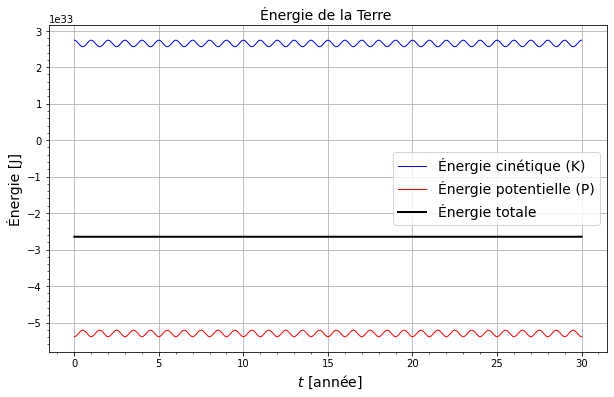

In [11]:
initial_time = 0
final_time = 3.156e7*30 # 30 ans
h = 3600   # Une heure

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  #Vitesse en m/s

orbit_earth = Verlet_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)

tpoints_verlet, P_verlet, K_verlet, total_energy_verlet = orbit_earth.get_energies(initial_value=initial_time, 
                                                                                   final_value=final_time, 
                                                                                   h=h
                                                                                  )

tpoints_verlet = tpoints_verlet/3.156e7

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints_verlet, K_verlet, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints_verlet, P_verlet, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


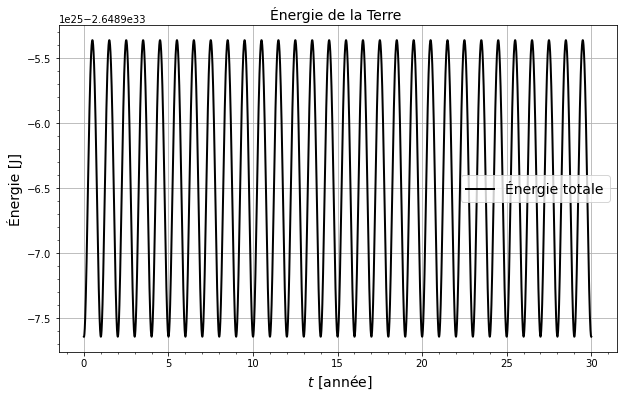

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observations:



#### Question f)

In [13]:
class RK2_solver(RK4_solver):
    """
    Cette classe définit la méthode de Runge-Kutta d'ordre 2 
    qui peut être utilisée pour résoudre les équations différentielles 
    décrivant le mouvement d'un corps en orbite autour d'un 
    autre, soit le Soleil dans le cas présent.
    """
    

    def get_energies(self, initial_value: float, final_value: float, N: int) -> tuple:
        """
        Getter des énergies cinétique, potentielle et totale.
        
        Parameters
        ----------
        initial_value: Valeur initiale de la variable indépendante. (float)
        final_value: Valeur finale de la variable indépendante. (float)
        N: Nombre de tranches utilisées. (float)

        Returns
        -------
        tpoints, P, K, total_energy: Le temps, l'énergie potentielle, l'énergie cinétique et l'énergie totale. (tuple)
        """
        G = const.G
        M = const.M_sun
        m = const.M_earth
    
        h = (final_value-initial_value)/N
        tpoints = np.arange(initial_value, final_value, h)
        P = [] #Énergie potentielle 
        K = [] #Énergie cinétique
        
        r = np.array(self.initial_conditions, float)
        
        for t in tpoints:
            R = np.sqrt(r[0]**2 + r[1]**2)
            P.append(-G.value * M.value * m.value / R)
            K.append(0.5 * m.value * (r[2]**2 + r[3]**2))
            
            r += self.get_delta(r, h)
        
        total_energy = np.array(K, float) + np.array(P, float)
        
        return tpoints, P, K, total_energy
        
    
    def get_delta(self, r: np.ndarray, h: float) -> float:
        """
        Getter de la valeur de la mise à jour à effectuer sur les variables du système d'équation.
        
        Parameters
        ----------
        r: Les valeurs des différentes variables du système. (np.ndarray)
        h: La grandeur du pas à effectuer. (float) 

        Returns
        -------
        delta: La mise à jour à effectuer sur les différentes variables du système. (float)
        """
        k1 = h*self.func(r)
        k2 = h*self.func(r+0.5*k1)
        delta = k2
        
        return delta


In [14]:
initial_time = 0
final_time = 3.156e7*2 # 2 ans
N = 100_000

x0 = 1.4710*10**11
y0 = 0
vx0 = 0    
vy0 = 3.0287*10**4  # Vitesse en m/an

initial_conditions = [x0, y0, vx0, vy0]
orbit_earth = RK2_solver(func=gravitational_differential_equations, initial_conditions=initial_conditions)


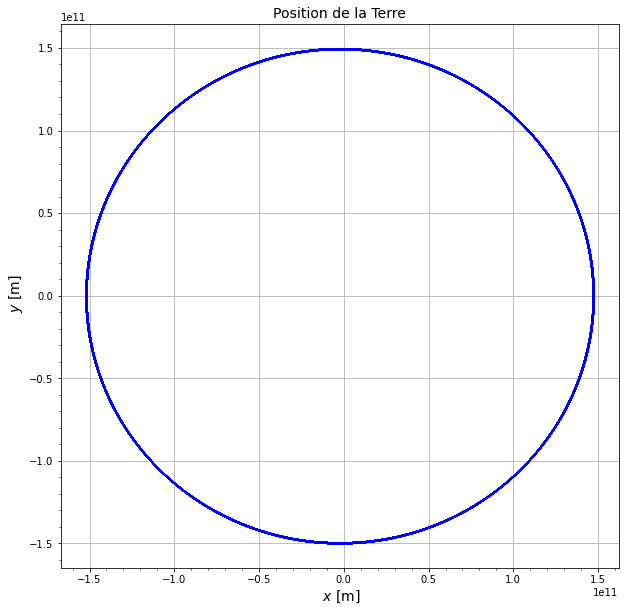

In [15]:
xpoints, ypoints = orbit_earth.solve(initial_value=initial_time, final_value=final_time, N=N)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)

orbit1, = ax.plot(xpoints, ypoints, marker='o', ls='None', color='b', markersize=0.3)

ax.set_title("Position de la Terre", fontsize=14)
ax.set_xlabel(" $x$ [m]", fontsize=14)
ax.set_xlim()
ax.set_ylabel(" $y$ [m]", fontsize=14)
ax.minorticks_on()

plt.grid()
plt.show()
plt.close(fig)


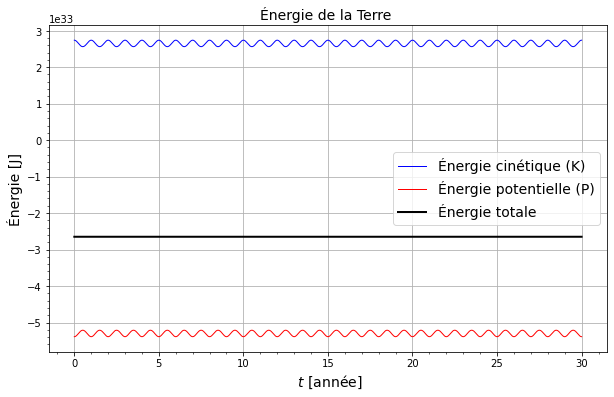

In [16]:
initial_time = 0
final_time = 3.156e7*30
N = 100_000

tpoints_rk2, P_rk2, K_rk2, total_energy_rk2 = orbit_earth.get_energies(initial_value=initial_time, 
                                                                       final_value=final_time, 
                                                                       N=N
                                                                      )
tpoints_rk2 = tpoints_rk2/3.156e7

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

kinetic, = ax.plot(tpoints_rk2, K_rk2, ls='-', color='b', linewidth='1', label="Énergie cinétique (K)")
potential, = ax.plot(tpoints_rk2, P_rk2, ls='-', color='r', linewidth='1', label="Énergie potentielle (P)")
energy_sum, = ax.plot(tpoints_rk2, total_energy_rk2, ls='-', color='k', linewidth='2', label="Énergie totale" )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[kinetic, potential, energy_sum], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


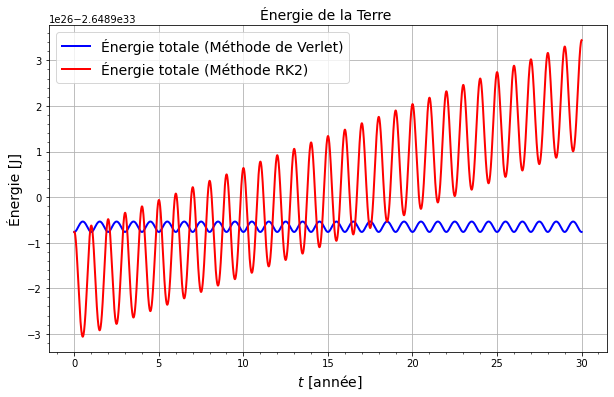

In [17]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

energy_sum_verlet, = ax.plot(tpoints_verlet, total_energy_verlet, ls='-', color='b', linewidth='2', 
                            label="Énergie totale (Méthode de Verlet)"
                           )

energy_sum_rk2, = ax.plot(tpoints_rk2, total_energy_rk2, ls='-', color='r', linewidth='2', 
                          label="Énergie totale (Méthode RK2)"
                         )

ax.set_title("Énergie de la Terre ", fontsize=14)
ax.set_xlabel(" $t$ [année]", fontsize=14)
ax.set_xlim()
ax.set_ylabel("Énergie [J]", fontsize=14)
ax.minorticks_on()

plt.legend(handles=[energy_sum_verlet, energy_sum_rk2], fontsize=14, loc='best')
plt.grid()
plt.show()
plt.close(fig)


Observation : https://femto-physique.fr/omp/methode-de-verlet.php#:~:text=Un%20des%20algorithmes%20symplectiques%20les,))%2Bh33!


#### Question g)

### Mécanique céleste - Mars

#### Question h)